<a href="https://colab.research.google.com/github/Luka-sasko/OSIRV-Facenet/blob/main/Facenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset from kaggle


In [ ]:
# Install Kaggle package
!pip install kaggle

# Upload the Kaggle API key file
from google.colab import files
uploaded = files.upload()

# Move the API Key
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d kenny3s/casia-webface

# Unzip the dataset
import zipfile
with zipfile.ZipFile('casia-webface.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/casia-webface')


In [4]:
import os

dataset_directory = '/content/casia-webface/datasets'

# Get a list of all directories in the dataset_directory
person_directories = [d for d in os.listdir(dataset_directory) if os.path.isdir(os.path.join(dataset_directory, d))]
count_persons=0
count_img=0
# Iterate over the first 10 person directories
for person_dir in person_directories[:10]:
    person_path = os.path.join(dataset_directory, person_dir)

    # Check if it's a directory before trying to list its contents
    if os.path.isdir(person_path):
        num_images = len(os.listdir(person_path))
        print(f"Person: {person_dir}, Number of images: {num_images}")

# Iterate over the  person directories
for person_dir in person_directories:
    person_path = os.path.join(dataset_directory, person_dir)

    # Check if it's a directory before trying to list its contents
    if os.path.isdir(person_path):
        num_images = len(os.listdir(person_path))
        count_persons+=1
        count_img+=num_images

print(f"Total Persons: {count_persons}")
print(f"Total Images: {count_img}")

Person: 1650932, Number of images: 25
Person: 3236159, Number of images: 22
Person: 0105876, Number of images: 12
Person: 5423912, Number of images: 16
Person: 4183917, Number of images: 47
Person: 0527592, Number of images: 21
Person: 0470941, Number of images: 18
Person: 0797373, Number of images: 41
Person: 0000293, Number of images: 109
Person: 0320448, Number of images: 20
Total Persons: 10575
Total Images: 452960


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.1 MB/s eta 0:00:00


  0%|          | 0.00/107M [00:00<?, ?B/s]

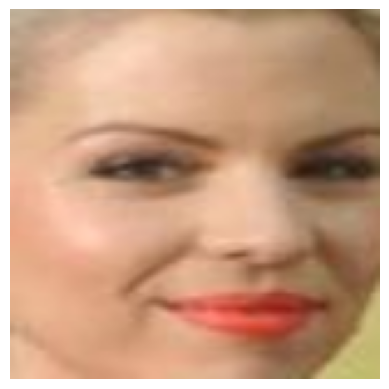

No face detected in the image for person: 3236159


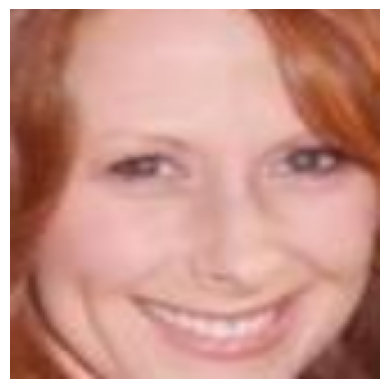

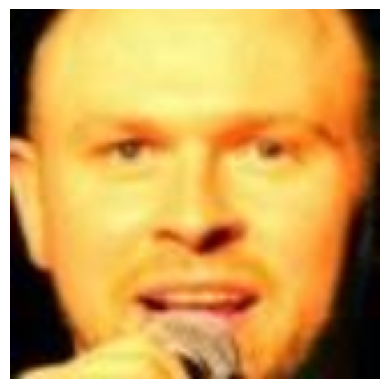

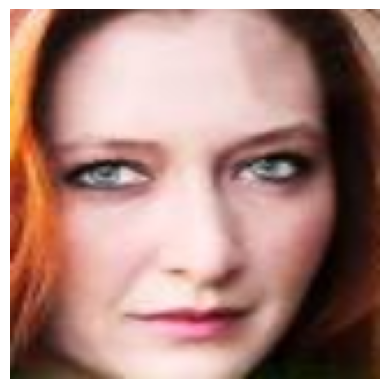

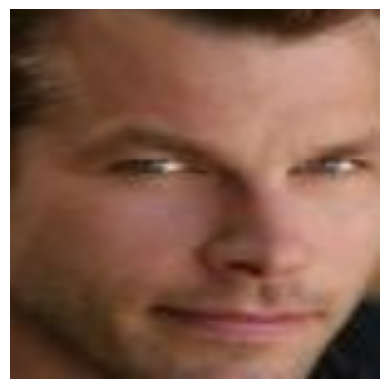

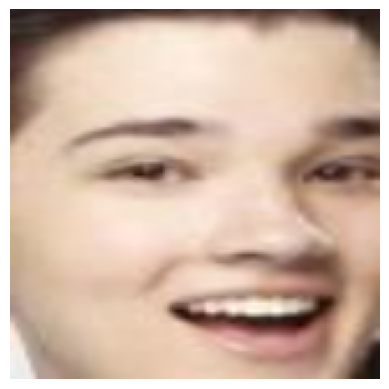

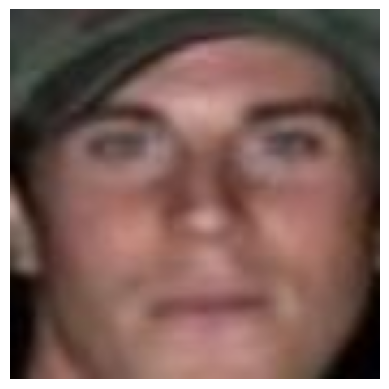

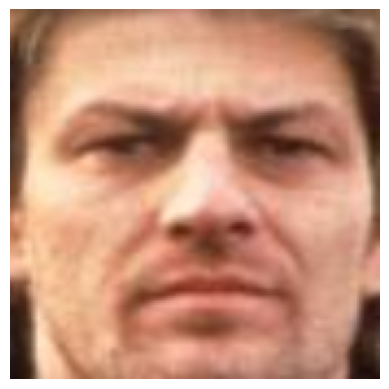

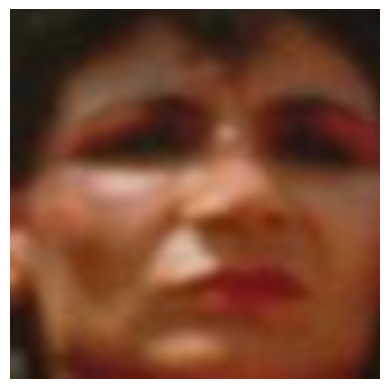

In [5]:
!pip install facenet-pytorch
!pip install matplotlib

import os
import torch
import cv2
import numpy as np
from facenet_pytorch import InceptionResnetV1, MTCNN
import matplotlib.pyplot as plt

# Function to extract face from image
def extract_face(img, box, image_size=160):
    x, y, width, height = box
    x, y, width, height = int(x), int(y), int(width), int(height)

    if x < 0:
        x = 0
    if y < 0:
        y = 0
    if width > img.shape[1]:
        width = img.shape[1]
    if height > img.shape[0]:
        height = img.shape[0]

    face = img[y: y + height, x: x + width]

    if face.size == 0:
        return np.zeros((image_size, image_size, 3))
    else:
        return cv2.resize(face, (image_size, image_size))

# Load pre-trained FaceNet model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)
mtcnn = MTCNN(keep_all=True, device=device)

# Dataset directory path
dataset_directory = '/content/casia-webface/datasets'

# Get a list of all directories in the dataset_directory
person_directories = [d for d in os.listdir(dataset_directory) if os.path.isdir(os.path.join(dataset_directory, d))]

# Use only the first 10 persons for demonstration
selected_persons = person_directories[:10]

# Display one image for each of the first 10 persons
for person_dir in selected_persons:
    person_path = os.path.join(dataset_directory, person_dir)
    person_images = [cv2.imread(os.path.join(person_path, filename)) for filename in os.listdir(person_path)]

    # Display the first image for each person
    if person_images:
        boxes, _ = mtcnn.detect(person_images[0])

        if boxes is not None and len(boxes) > 0:
            box = boxes[0]
            face = extract_face(person_images[0], box)
            face_tensor = mtcnn(face)

            # Continue with processing only if face_tensor is not None
            # Continue with processing only if face_tensor is not None
            if face_tensor is not None:
                face_tensor = face_tensor.squeeze(0).to(device)  # Squeeze the extra dimension
                embedding = model(face_tensor.unsqueeze(0)).detach().cpu().numpy()  # Use detach()

                # Display the image
                plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
                plt.axis('off')
                plt.show()
            else:
                print(f"No face detected in the image for person: {person_dir}")
        else:
            print(f"No face detected in the image for person: {person_dir}")
    else:
        print(f"No images found for person: {person_dir}")



# **Iteracija za cijeli dataset**

In [ ]:
# Instalacija potrebnih biblioteka
!pip install mtcnn
!pip install facenet-pytorch

# Uvoz potrebnih biblioteka
import torch
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
from facenet_pytorch import InceptionResnetV1, MTCNN

# Funkcija za ekstrakciju lica
def extract_face(img, box, image_size=160):
    x, y, width, height = box
    x, y, width, height = int(x), int(y), int(width), int(height)

    # Provjera da li su koordinate okvira unutar granica slike
    if x < 0:
        x = 0
    if y < 0:
        y = 0
    if width > img.shape[1]:
        width = img.shape[1]
    if height > img.shape[0]:
        height = img.shape[0]

    # Ekstrakcija lica
    face = img[y: y + height, x: x + width]

    # Promjena veličine lica na željenu veličinu slike
    if face.size == 0:
        return np.zeros((image_size, image_size, 3))
    else:
        return cv2.resize(face, (image_size, image_size))
def extract_embeddings(images, mtcnn, model):
    embeddings = []
    for img in images:
        boxes, probs = mtcnn.detect(img)
        if boxes is not None and len(boxes) > 0:
            # Extract only the first detected face
            box = boxes[0]
            face = extract_face(img, box, image_size=160)
            if face is not None and len(face.shape) > 0 and face.size != 0:
                with torch.no_grad():
                    face_tensor = mtcnn(face)
                    if face_tensor is not None:  # Add this check to handle cases where face_tensor is None
                        face_tensor = face_tensor.to(device)
                        embedding = model(face_tensor).cpu().numpy()
                        embeddings.append(embedding)
    return embeddings


# Funkcija za učitavanje slika iz direktorija osobe
def load_images(person_path):
    images = []
    for filename in os.listdir(person_path):
        img_path = os.path.join(person_path, filename)
        img = cv2.imread(img_path)
        images.append(img)
    return images

# Postavljanje uređaja (cuda - GPU, cpu - CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Učitavanje prethodno treniranog FaceNet modela
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)
mtcnn = MTCNN(keep_all=True, device=device)

# Putanja do direktorija CASIA-WebFace skupa podataka
dataset_directory = '/content/casia-webface/datasets'

# Učitavanje slika i oznaka za svaku osobu u skupu podataka
X, y = [], []
for person_label, person_dir in enumerate(os.listdir(dataset_directory)):
    person_path = os.path.join(dataset_directory, person_dir)
    person_images = load_images(person_path)
    person_embeddings = extract_embeddings(person_images, mtcnn, model)

    X.extend(person_embeddings)
    y.extend([person_label] * len(person_embeddings))

# Razdvajanje skupa podataka na skup za treniranje i skup za validaciju
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Ispis broja uzoraka u skupu za treniranje i skupu za validaciju
print(f"Broj uzoraka u skupu za treniranje: {len(X_train)}")
print(f"Broj uzoraka u skupu za validaciju: {len(X_valid)}")


# Iteracija za samo 25% slika


In [ ]:
import torch

# Check if GPU is available
print(f"GPU Available: {torch.cuda.is_available()}")

# Check the current device
print(f"Current device: {torch.cuda.current_device()}")


In [ ]:
import os
import torch
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from facenet_pytorch import InceptionResnetV1, MTCNN

# Function to extract face from image
def extract_face(img, box, image_size=160):
    x, y, width, height = box
    x, y, width, height = int(x), int(y), int(width), int(height)

    if x < 0:
        x = 0
    if y < 0:
        y = 0
    if width > img.shape[1]:
        width = img.shape[1]
    if height > img.shape[0]:
        height = img.shape[0]

    face = img[y: y + height, x: x + width]

    if face.size == 0:
        return np.zeros((image_size, image_size, 3))
    else:
        return cv2.resize(face, (image_size, image_size))

def extract_embeddings(images, mtcnn, model):
    embeddings = []
    for img in images:
        boxes, probs = mtcnn.detect(img)
        if boxes is not None and len(boxes) > 0:
            box = boxes[0]
            face = extract_face(img, box, image_size=160)
            if face is not None and len(face.shape) > 0 and face.size != 0:
                with torch.no_grad():
                    face_tensor = mtcnn(face)
                    if face_tensor is not None:
                        face_tensor = face_tensor.to(device)
                        embedding = model(face_tensor).cpu().numpy()
                        # Average the embeddings
                        avg_embedding = np.mean(embedding, axis=0)
                        embeddings.append(avg_embedding)
    return embeddings

def load_images(person_path):
    images = []
    for filename in os.listdir(person_path):
        img_path = os.path.join(person_path, filename)
        img = cv2.imread(img_path)
        images.append(img)
    return images

# Set device (cuda - GPU, cpu - CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load pre-trained FaceNet model
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)
mtcnn = MTCNN(keep_all=True, device=device)

# Dataset directory path
dataset_directory = '/content/casia-webface/datasets'

# Get a list of all directories in the dataset_directory
person_directories = [d for d in os.listdir(dataset_directory) if os.path.isdir(os.path.join(dataset_directory, d))]

# Use only 25% of persons
selected_persons = person_directories[:int(0.25 * len(person_directories))]

# Load images and labels for selected persons
X, y = [], []
for person_label, person_dir in enumerate(selected_persons):
    person_path = os.path.join(dataset_directory, person_dir)
    person_images = load_images(person_path)
    person_embeddings = extract_embeddings(person_images, mtcnn, model)

    X.extend(person_embeddings)
    y.extend([person_label] * len(person_embeddings))

# Split dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the number of samples in the training and validation sets
print(f"Number of samples in the training set: {len(X_train)}")
print(f"Number of samples in the validation set: {len(X_valid)}")

# Classification:
 Use the embeddings to train a classifier for specific facial attributes, emotions, or other characteristics. For example, you can train a model to classify facial expressions or determine the gender of individuals.

In [ ]:
!pip install scikit-learn

In [ ]:

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train a Support Vector Machine (SVM) classifier
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = clf.predict(X_valid)

# Calculate and print the accuracy
accuracy = accuracy_score(y_valid, y_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
